## Import and setup functions

In [35]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.pyplot as plt
from scipy import optimize
from autograd import jacobian
# from google.colab import files

def oneE(r, D, beta, r0):
    """ Function to calculate oneE
    """
    return D*(1.0 - np.exp(-beta*(r - r0)))**2 - D
    
def triE(r, D, beta, r0):
    """ Function to calculate triE
    """
    return D*(1.0 + np.exp(-beta*(r - r0)))**2 - D

def potential(r_vec):
    """ Function to calculate potential energy given the distance between particles

    Args:
        R (np.array): vector with inter particle distances
    Return:
        float: potential energy
    """
    r1, r2, r3 = r_vec
    
    Q1  = 0.5*(oneE(r1, D=234.524674, beta=0.929968, r0=1.776382) + triE(r1, D=220.244820, beta=4.822681, r0=1.785014))

    Q2  = 0.5*(oneE(r2, D=234.524674, beta=0.929968, r0=1.776382) + triE(r2, D=220.244820, beta=4.822681, r0=1.785014))
  
    Q3  = 0.5*(oneE(r3, D=64.925971, beta=0.432955, r0=2.094857) + triE(r3, D=284.999867, beta=1.016811, r0=2.186060))
  
    J1  = 0.5*(oneE(r1, D=234.524674, beta=0.929968, r0=1.776382) - triE(r1, D=220.244820, beta=4.822681, r0=1.785014))

    J2  = 0.5*(oneE(r2, D=234.524674, beta=0.929968, r0=1.776382) - triE(r2, D=220.244820, beta=4.822681, r0=1.785014))

    J3  = 0.5*(oneE(r3, D=64.925971, beta=0.432955, r0=2.094857) - triE(r3, D=284.999867, beta=1.016811, r0=2.186060))

    result = Q1 + Q2 + Q3 - np.sqrt(J1**2 + J2**2 + J3**2
    - J1*J2 - J2*J3 - J3*J1) + 234.524674 
  
    return result

def rxn_coord(R):
    """ Calculate reaction coordinate

    Args:
        R (np.array): particle position vector
    Return:
        float: value of reaction coordinate
    """
    r1 = np.sqrt((R[0][0]-R[1][0])**2 + (R[0][1]-R[1][1])**2)
    r2 = np.sqrt((R[1][0]-R[2][0])**2 + (R[1][1]-R[2][1])**2)
    return r1-r2

def leps_potential(pos):
    """ Calculate total potential including umbrella sampling bias
    """
    # pass this as an argument
    q0=1
    r1 = np.sqrt((pos[0][0]-pos[1][0])**2 + (pos[0][1]-pos[1][1])**2)
    r2 = np.sqrt((pos[1][0]-pos[2][0])**2 + (pos[1][1]-pos[2][1])**2)
    r3 = np.sqrt((pos[0][0]-pos[2][0])**2 + (pos[0][1]-pos[2][1])**2)
    r_vec = np.asarray([r1, r2, r3])
    PE = potential(r_vec) + 0.5*5*(rxn_coord(pos)-q0)**2
    
    return PE


def my_kinetic_energy(vel, mass):
    """ Calculate total kinetic energy.

    Args:
        vel (np.array): particle velocities, shape (natom, ndim)
        mass (float): particle mass
    Return:
        float: total kinetic energy
    """
    tot_ke = 0
    for i in range(0,len(vel)):
          tot_ke = tot_ke + 0.5*mass[i][0]*np.sum(vel[i]*vel[i])

    return 2390.06*tot_ke

def VerletNextR(r_t, v_t, f_t, h,mass):
    """Return new positions after one Verlet step"""

    r_t_plus_h = r_t + v_t*h + 0.5*np.divide(f_t,mass)*h*h
    return r_t_plus_h


def VerletNextV(v_t,f_t,f_t_plus_h,h,mass):
    """Return new velocities after one Verlet step"""

    v_t_plus_h = v_t + 0.5*np.divide((f_t + f_t_plus_h),mass)*h
    return v_t_plus_h


def Langevin_int(v_t,r_t,f_t,h,mass,gamma,T):
    """Return new velocities after one Verlet step"""

    kb = 1.987204*10**(-3)
    sigma = np.sqrt((4.184*(10**(-4))*2*kb*T*gamma)/mass)
    eta = np.random.normal(0,1,(3,2))
    theta = np.random.normal(0,1,(3,2))
    C = 0.5*(h**2)*(np.divide(f_t,mass) - gamma*v_t) + sigma*((h)**(1.5))*(0.5*eta + (1/(2*np.sqrt(3)))*theta)
    r_t_plus_h = r_t + h*v_t + C
    f_t_plus_h = -4.184*(10**(-4))*forces(r_t_plus_h)
    v_t_plus_h = v_t + 0.5*h*np.divide((f_t+f_t_plus_h),mass) - h*gamma*v_t + sigma*(np.sqrt(h))*eta - gamma*C

    return  r_t_plus_h, v_t_plus_h


def Langevin_int_first(r_t,f_t,h,mass,gamma,T):
    """Return new velocities after one Verlet step"""

    kb = 1.987204*10**(-3)
    sigma = np.sqrt((4.184*(10**(-4))*2*kb*T*gamma)/mass)
    eta = np.random.normal(0,1,(3,2))


    r_t_plus_h = r_t + np.divide(f_t,mass)*(h/gamma) + np.sqrt(4.184*(10**(-4))*2*kb*T/(mass*gamma))*eta*np.sqrt(h)
    v_t_plus_h =  (r_t_plus_h - r_t)/h

    return  r_t_plus_h, v_t_plus_h


def Langevin_int_first_2(r_t,v_t,f_t,h,mass,gamma,T):
    """Return new velocities after one Verlet step"""

    kb = 1.987204*10**(-3)
    sigma = np.sqrt((4.184*(10**(-4))*2*kb*T*gamma)/mass)
    eta = np.random.normal(0,1,(3,2))  
    r_t_plus_h = r_t +h*v_t 
    v_t_plus_h =  v_t + h*np.divide(f_t,mass) - h*gamma*v_t +np.sqrt(h)*sigma*eta

    return  r_t_plus_h, v_t_plus_h

# AUTOGRAD FOR FORCES
forces = jacobian(leps_potential)

## Initialize system

In [36]:
# INITIALIZE SYSTEM
R = np.zeros((3,2))
V = np.zeros((3,2))
steps = 2000
count = 1
eq_steps=1000
dump_step=10
q = []
R[0][0] = -2.
R[0][1] = 0.

R[1][0] = 0.
R[1][1] = 0.1

R[2][0] = 3.
R[2][1] = 0.



E = np.zeros(steps)
q = np.zeros(steps)
r1 = np.zeros(steps)
r2 = np.zeros(steps)
F = np.zeros((3,2))
V = np.zeros((3,2))
h = 1

#temperature
T = 300

# masses
mass = np.zeros((3,2))

mass[0][0] = 38
mass[0][1] = 38

mass[1][0] = 15
mass[1][1] = 15

mass[2][0] = 38
mass[2][1] = 38

kb = 1.987204*10**(-3)



## Effect of gamma on temperature control

Text(0, 0.5, 'Temperature (K)')

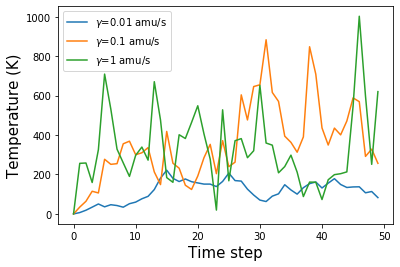

In [37]:
count = 1
count2 = 0
g = [0.01, 0.1, 1]
q0=0


E = np.zeros((3,steps))
for gam in g:
    gamma = gam

    R[0][0] = -2.
    R[0][1] = 0.

    R[1][0] = 0.
    R[1][1] = 0.1

    R[2][0] = 3.
    R[2][1] = 0.
    F = np.zeros((3,2))
    V = np.zeros((3,2))

    for i in range(0,steps):

        E[count2][i] = 1.15*my_kinetic_energy(V, mass)/(3*1.987204*10**(-3))

        F = -4.184*(10**(-4))*forces(R)

        nR, nV = Langevin_int(V,R,F,h,mass,gamma,T)
        R, V = nR, nV
  
    count2 = count2 + 1

p1, = plt.plot(E[0][0:50], label = r'$\gamma$=0.01 amu/s')
p2, = plt.plot(E[1][0:50], label = r'$\gamma$=0.1 amu/s')
p3, = plt.plot(E[2][0:50], label = r'$\gamma$=1 amu/s')
plt.legend(handles = [p1, p2, p3])
plt.xlabel("Time step", Fontsize = 15)
plt.ylabel("Temperature (K)", Fontsize = 15)

## Run MD and write order parameter to file

In [38]:
f  = open("Time_Series.txt", "w")

for i in range(0,steps):

  F = -4.184*(10**(-4))*forces(R)

  nR, nV = Langevin_int(V,R,F,h,mass,gamma,T)

  R, V = nR, nV

  if i > eq_steps and i%dump_step==0:
    r1 = np.sqrt((R[0][0]-R[1][0])**2 + (R[0][1]-R[1][1])**2)
    r2 = np.sqrt((R[1][0]-R[2][0])**2 + (R[1][1]-R[2][1])**2)
    f.write(str(count)+"\t"+str(r1-r2)+"\n")
    count = count + 1
 
f.close()
